<a href="https://colab.research.google.com/github/jaketakes/cogs118b-final-project/blob/bassam/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from scipy.io import loadmat
import pandas as pd
import kagglehub
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## General rules
1. update group when working and what sections
2. Try to be comprehensive as you write! Leave short markdown descriptions for the average reader to understand what you're doing

## Overview
### [FILL IN WITH PROJECT DESCRIPTION]

## Data

In [3]:
# Download latest version
path = kagglehub.dataset_download("eduardo4jesus/stanford-cars-dataset")

print("Path to dataset files:", path)

100%|██████████| 1.82G/1.82G [00:47<00:00, 41.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/eduardo4jesus/stanford-cars-dataset/versions/1


In [4]:
# Explore directories/files
print("Path:", path)
print("Folders/files inside the dataset:")
dir = os.listdir(path)
print(dir)
devpath = path + '/car_devkit/devkit'
print('Files inside devkit')
print(os.listdir(devpath))
metapath = devpath + "/cars_meta.mat"

Path: /root/.cache/kagglehub/datasets/eduardo4jesus/stanford-cars-dataset/versions/1
Folders/files inside the dataset:
['cars_train', 'car_devkit', 'cars_test']
Files inside devkit
['cars_meta.mat', 'train_perfect_preds.txt', 'eval_train.m', 'README.txt', 'cars_test_annos.mat', 'cars_train_annos.mat']


In [5]:
meta = loadmat(metapath)

train_dir = os.path.join(path, 'cars_train' )
test_dir = os.path.join(path, 'cars_test')
class_names = [c[0] for c in meta["class_names"][0]]
class_index = range(1, len(class_names) + 1) # classes are labeled w/ 1 based labeling

classes = pd.DataFrame( {
    "label": class_index,
    "class_names" : class_names
})
classes

,label,class_names
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012
...,...,...
191,192,Volkswagen Beetle Hatchback 2012
192,193,Volvo C30 Hatchback 2012
193,194,Volvo 240 Sedan 1993
194,195,Volvo XC90 SUV 2007


In [6]:
train_ann = loadmat(os.path.join(devpath, 'cars_train_annos.mat'))
train_ann = train_ann["annotations"][0] # index 4 is label for each train image
test_ann = loadmat(os.path.join(devpath, 'cars_test_annos.mat'))
test_ann = test_ann["annotations"][0] # no test labels, will split up train_ann to train/test
train_labels = [i[4][0][0] for i in train_ann]
file_names = [i[5][0] for i in train_ann]


data_dict = {
    "filen" : file_names,
    "train_labels" : train_labels
}

data = pd.DataFrame(data_dict)

data["class_name"] = data["train_labels"].map(
    dict(zip(classes["label"], classes["class_names"]))
)
data

,filen,train_labels,class_name
0,00001.jpg,14,Audi TTS Coupe 2012
1,00002.jpg,3,Acura TL Sedan 2012
2,00003.jpg,91,Dodge Dakota Club Cab 2007
3,00004.jpg,134,Hyundai Sonata Hybrid Sedan 2012
4,00005.jpg,106,Ford F-450 Super Duty Crew Cab 2012
...,...,...,...
8139,08140.jpg,78,Chrysler Town and Country Minivan 2012
8140,08141.jpg,196,smart fortwo Convertible 2012
8141,08142.jpg,163,Mercedes-Benz SL-Class Coupe 2009
8142,08143.jpg,112,Ford GT Coupe 2006


## Body types work:

In [7]:
body_types = [
    "Coupe", "Sedan", "SUV", "Hatchback",
    "Convertible", "Minivan", "Wagon", "Crossover", "Van", "Cab"
]

def find_body_type(name):
    name_lower = name.lower()

    for body in body_types:
        if body.lower() in name_lower:
            return body
    #coupes
    if any(x in name_lower for x in ["corvette", "camaro", "mustang", "challenger", "370z", "350z", "supra", "xk", "xkr", "integra", "gallardo"]):
        return "Coupe"

    # Sedans
    if any(x in name_lower for x in ["charger", "chrysler 300", "cobalt", "impala", "malibu", "accord", "civic", "corolla",
                                     "jetta", "regal", "tl type-s"]):
        return "Sedan"

    # SUVs
    if any(x in name_lower for x in ["grand cherokee", "cherokee", "durango", "rav4", "cr-v", "crv", "rogue", "highlander", "pilot", "tahoe",
                                     "explorer", "escape", "equinox","trailblazer"]):
        return "SUV"

    #hatchbacks
    if any(x in name_lower for x in ["golf", "fit", "hhr", "impreza hatch", "mazda3 hatch", "sportwagen","fiat 500"]):
        return "Hatchback"

    # Trucks
    if any(x in name_lower for x in ["f-150", "f150", "f-250", "ram", "silverado", "sierra", "tacoma", "tundra", "ranger", "colorado"]):
        return "Truck"

    # Vans / Minivans
    if any(x in name_lower for x in ["caravan", "odyssey", "sienna", "transit", "express van", "sprinter"]):
        return "Van"

    # other
    if "srt" in name_lower or "ss" in name_lower or "hellcat" in name_lower or "z06" in name_lower or "zl1" in name_lower:
        if any(x in name_lower for x in ["charger", "chrysler 300", "cts"]):
            return "Sedan"
        if any(x in name_lower for x in ["corvette", "camaro", "challenger", "mustang"]):
            return "Coupe"

    if "cab" in name_lower:
        return "Cab"
    return "Unknown"

data["body type"] = data["class_name"].apply(find_body_type)
data.loc[data["body type"] == "Cab", "body type"] = "Truck"
data.loc[data["body type"] == "Minivan", "body type"] = "Van"

In [8]:
data

,filen,train_labels,class_name,body type
0,00001.jpg,14,Audi TTS Coupe 2012,Coupe
1,00002.jpg,3,Acura TL Sedan 2012,Sedan
2,00003.jpg,91,Dodge Dakota Club Cab 2007,Truck
3,00004.jpg,134,Hyundai Sonata Hybrid Sedan 2012,Sedan
4,00005.jpg,106,Ford F-450 Super Duty Crew Cab 2012,Truck
...,...,...,...,...
8139,08140.jpg,78,Chrysler Town and Country Minivan 2012,Van
8140,08141.jpg,196,smart fortwo Convertible 2012,Convertible
8141,08142.jpg,163,Mercedes-Benz SL-Class Coupe 2009,Coupe
8142,08143.jpg,112,Ford GT Coupe 2006,Coupe


In [9]:
unknowns = data[data["body type"] == "Unknown"]
print(unknowns)


Empty DataFrame
Columns: [filen, train_labels, class_name, body type]
Index: []


Body types end

In [10]:
# Need to construct custom Dataset Class to later use for DataLoader for models
class CarsDataset(Dataset):
    def __init__(self, df, images_dir, transform=None, supervised=True, use_body_type=False, body_type_to_idx=None):
        self.df = df
        self.images_dir = images_dir
        self.transform = transform
        self.supervised = supervised
        self.use_body_type = use_body_type
        self.body_type_to_idx = body_type_to_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, ind):
        row = self.df.iloc[ind]
        # images_dir is already the correct path (either the nested cars_train/cars_train or cars_test)
        # So we just need to join the filename directly
        img_path = os.path.join(self.images_dir, row["filen"]) # path to specific image
        img = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        if self.supervised:
            if self.use_body_type and self.body_type_to_idx is not None:
                # Use body type label
                body_type = row["body type"]
                label = self.body_type_to_idx[body_type]
            else:
                # Use original car model label
                label = row["train_labels"]
            return img, label
        else: # unsupervised; no image needed
            return img

## Supervised Learning
### We applied supervised learning to classify car images by body type using labeled examples from the Stanford Cars dataset. We used a pretrained ResNet50 convolutional neural network and fine-tuned its final classification layer to predict body-type categories such as sedan, coupe, and SUV.

In [11]:
# Define transformations on images
res_transforms = transforms.Compose(
    [
        transforms.Resize((224,224)), #resnets expect 224,224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet normalization
    ]
)

In [12]:
# Split dataset into train/val/test (70/15/15)
train_df, valtest_df = train_test_split(data, test_size=0.3, stratify=data["train_labels"])
val_df, test_df = train_test_split(valtest_df, test_size=0.5, stratify=valtest_df["train_labels"])


In [13]:
# Handle nested directory structure (images are in cars_train/cars_train/)
train_dir = os.path.join(train_dir, 'cars_train')
print(f"Using nested directory: {train_dir}")


Using nested directory: /root/.cache/kagglehub/datasets/eduardo4jesus/stanford-cars-dataset/versions/1/cars_train/cars_train


Lets setup for Body Type Prediction (instead of 196 car models)

In [14]:
# Get unique body types and create mapping
unique_body_types = sorted(data["body type"].unique())
body_type_to_idx = {body_type: idx for idx, body_type in enumerate(unique_body_types)}
idx_to_body_type = {idx: body_type for body_type, idx in body_type_to_idx.items()}

num_body_types = len(unique_body_types)
print(f"Body types to predict: {unique_body_types}")
print(f"Number of body type classes: {num_body_types}")
print(f"Body type mapping: {body_type_to_idx}")

# Recreate datasets with body type labels
train_data = CarsDataset(train_df, train_dir, transform=res_transforms, supervised=True,
                        use_body_type=True, body_type_to_idx=body_type_to_idx)
val_data = CarsDataset(val_df, train_dir, transform=res_transforms, supervised=True,
                      use_body_type=True, body_type_to_idx=body_type_to_idx)
test_data = CarsDataset(test_df, train_dir, transform=res_transforms, supervised=True,
                       use_body_type=True, body_type_to_idx=body_type_to_idx)

print(f"\nDatasets recreated for body type prediction")


Body types to predict: ['Convertible', 'Coupe', 'Hatchback', 'SUV', 'Sedan', 'Truck', 'Van', 'Wagon']
Number of body type classes: 8
Body type mapping: {'Convertible': 0, 'Coupe': 1, 'Hatchback': 2, 'SUV': 3, 'Sedan': 4, 'Truck': 5, 'Van': 6, 'Wagon': 7}

Datasets recreated for body type prediction


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet50, ResNet50_Weights
import numpy as np


First, we will create DataLoaders for batching our data

In [16]:
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Train batches: 179
Val batches: 39
Test batches: 39


The reason we use DataLoader is because neural networks read the dataset in batches.

The batch size of 32 means each batch contains 32 images. With 179 training batches, 39 validation batches, and 39 test batches, the total number of images in each split aligns with our 70/15/15 train/validation/test split of the dataset.

We are also able to derive that there are about 5728 images in the training set (179 x 32). The validation and test sets each contain about 1,248 images.

## ResNet50 model

Now we are going to load in the ResNet50 model, using its pretrained ImageNet weights. The only thing we are training here is the last layer for our new task (predicting body types).

In [17]:
# Using number of body type classes (not 196 car models)
num_classes = num_body_types

# Load pretrained ResNet50 with ImageNet weights
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

# Replace the final fully connected layer for body type classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Model loaded on: {device}")
print(f"Number of classes (body types): {num_classes}")
print(f"Predicting: {unique_body_types}")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


Model loaded on: cuda
Number of classes (body types): 8
Predicting: ['Convertible', 'Coupe', 'Hatchback', 'SUV', 'Sedan', 'Truck', 'Van', 'Wagon']


We can see that there are 8 body types that we will try to predict, along with what the 8 body types are.

Next, we are going to set up the training configuration by defining our loss function, optimizer, and learning rate scheduler.

In [18]:
criterion = nn.CrossEntropyLoss()  # Standard classification loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

# Learning rate scheduler: reduces LR by factor of 0.1 every 7 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print("Loss function: CrossEntropyLoss")
print("Optimizer: Adam (lr=0.001)")
print("Scheduler: StepLR (step_size=7, gamma=0.1)")


Loss function: CrossEntropyLoss
Optimizer: Adam (lr=0.001)
Scheduler: StepLR (step_size=7, gamma=0.1)


For our loss function, we used CrossEntropyLoss, which is the standard choice for multi-class classification tasks. It works by comparing the model’s predicted probability distribution with the true body type label for each image and penalizing the model when it assigns low probability to the correct class.

For the optimizer, we used Adam, which adjusts the learning rate for each parameter based on the gradients. After each batch, Adam updates the model weights using the rule:

new_weights = old_weights − learning_rate × gradient


This update step is what enables the model to learn from its mistakes and gradually improve its predictions.


## Training Function

The next step we will take is training our function for one epoch, where in each epoch, the model will:
- Processes each batch of images
- Computes predictions
- Calculates the loss
- Backpropagates gradients
- Updates its weights
- Tracks training loss and accuracy

In [19]:
def train_epoch(model, train_loader, criterion, optimizer, device):

    model.train()  # This sets the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        # Move data to device (GPU or CPU)
        images = images.to(device)
        labels = labels.to(device)

        # this will clear the gradients from the previous batch
        optimizer.zero_grad()

        # forward pass: the model is computing its predictions
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backward pass: the model computes the gradients with respect to each model paramater, and tells teh optimizer how each weight should change.
        loss.backward()

        # now it will update the weights
        optimizer.step()

        # track statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)  # gets the predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader) # this is the average loss for the epoch
    epoch_acc = 100 * correct / total # this is the accuracy percentage for the epoch
    return epoch_loss, epoch_acc


### Example Image



lets take a look at an example image, and its corespoding predictions.

Predictions: {'Convertible': '0.1449', 'Coupe': '0.1415', 'Hatchback': '0.1183', 'SUV': '0.0976', 'Sedan': '0.1271', 'Truck': '0.1151', 'Van': '0.1181', 'Wagon': '0.1375'}


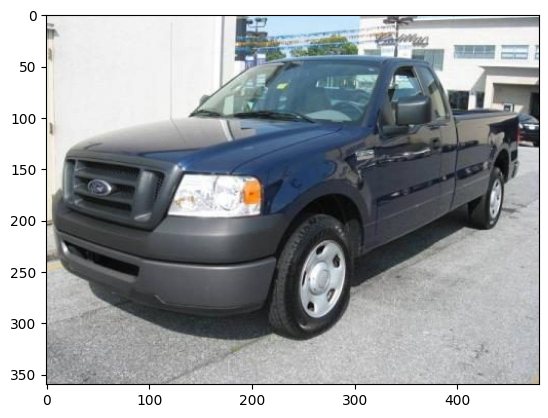

In [20]:
import torch.nn.functional as F

model.eval()
sample_image, sample_label = train_data[0]

with torch.no_grad():
    probs = F.softmax(model(sample_image.unsqueeze(0).to(device)), dim=1)[0].cpu().numpy()

plt.imshow(Image.open(os.path.join(train_dir, train_df.iloc[0]["filen"])))

print("Predictions:", {idx_to_body_type[i]: f"{p:.4f}" for i, p in enumerate(probs)})

Here we can see the image of the car, along with the predictions of it being each body type. The predicted probabilities over the eight body-type classes are all close to 10%-15%, which indicates that the model has not yet learned meaningful features for this task. Hopefully after training the model, it will be able to accurately predict the body type!

## Validation Funtion

Our next step is to set up the validation function. Over here, the function will evaluate the model's performance on unseen data, but unlike training, it will not update its weights, but only measures the average loss and classification accuracy.

In [21]:
def validate(model, val_loader, criterion, device):

    model.eval()  # this sets the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # this disables gradient computation
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            # there is only a forward pass here
            outputs = model(images) # this will compute the predictions
            loss = criterion(outputs, labels) #this will calculate the loss using CrossEntropyLoss again

            # Track statistics, we are tracking the loss for the current batch to then compute the average loss for the entire epoch
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1) # this finds the largest probability for each image and pulls the index of it
            total += labels.size(0) # adding the number of samples in each batch
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(val_loader) #this is the average loss for the epoch
    epoch_acc = 100 * correct / total # this is the accuracy percentage for the epoch
    return epoch_loss, epoch_acc


Now that we have our training and validation functions, we can train the model on the dataset. Each epoch represents one full pass through the training data. During each epoch, the model is trained on the training set, evaluated on the validation set, the learning rate is updated, and the training and validation loss and accuracy are recorded. The model is saved whenever the validation accuracy improves.

In [22]:
num_epochs = 15  # Number of complete passes through the training data
best_val_acc = 0.0

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 20)

    # train the model for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # update learning rate
    scheduler.step() # this will happen after every 7 epochs


    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    # if the model performs its best validation yet, it will save that model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_resnet50_model.pth')
        print(f'New best model saved! (Val Acc: {val_acc:.2f}%)')

print(f'\nTraining complete! Best validation accuracy: {best_val_acc:.2f}%')



Epoch 1/15
--------------------


KeyboardInterrupt: 

Finally, after training is complete and the best model has been saved, we run the test dataset through the model to get our evalutaion on its performance.

In [23]:
print("Evaluating on test set...")
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')


Evaluating on test set...


KeyboardInterrupt: 

In [24]:
# Setup for Car Model Prediction (196 classes)
num_classes_car = 196
idx_to_class_name = {i: classes.iloc[i]["class_names"] for i in range(len(classes))}

print(f"Task: Car Model Prediction")
print(f"Number of classes: {num_classes_car}")

# Recreate datasets with car model labels (not body types)
train_data_car = CarsDataset(train_df, train_dir, transform=res_transforms, supervised=True, use_body_type=False)
val_data_car = CarsDataset(val_df, train_dir, transform=res_transforms, supervised=True, use_body_type=False)
test_data_car = CarsDataset(test_df, train_dir, transform=res_transforms, supervised=True, use_body_type=False)

# Create DataLoaders
train_loader_car = DataLoader(train_data_car, batch_size=32, shuffle=True, num_workers=0)
val_loader_car = DataLoader(val_data_car, batch_size=32, shuffle=False, num_workers=0)
test_loader_car = DataLoader(test_data_car, batch_size=32, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader_car)}")
print(f"Val batches: {len(val_loader_car)}")
print(f"Test batches: {len(test_loader_car)}")


Task: Car Model Prediction
Number of classes: 196
Train batches: 179
Val batches: 39
Test batches: 39


In [25]:
# Set up ResNet50 model for Car Model Prediction
model_car = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
model_car.fc = nn.Linear(model_car.fc.in_features, num_classes_car)
model_car = model_car.to(device)

# Loss, optimizer, scheduler
criterion_car = nn.CrossEntropyLoss()
optimizer_car = optim.Adam(model_car.parameters(), lr=0.001)
scheduler_car = optim.lr_scheduler.StepLR(optimizer_car, step_size=7, gamma=0.1)

print(f"Model loaded on: {device}")
print(f"Number of classes: {num_classes_car}")


Model loaded on: cuda
Number of classes: 196


In [26]:
# Training functions for car models (labels need -1 conversion)
def train_epoch_car(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device) - 1  # Convert 1-indexed (1-196) to 0-indexed (0-195)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / len(train_loader), 100 * correct / total

def validate_car(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device) - 1  # Convert 1-indexed to 0-indexed

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / len(val_loader), 100 * correct / total


In [27]:
# Training loop for Car Model Prediction (15 epochs)
num_epochs_car = 15
best_val_acc_car = 0.0

train_losses_car = []
train_accs_car = []
val_losses_car = []
val_accs_car = []

for epoch in range(num_epochs_car):
    print(f'\nEpoch {epoch+1}/{num_epochs_car}')
    print('-' * 20)

    train_loss, train_acc = train_epoch_car(model_car, train_loader_car, criterion_car, optimizer_car, device)
    train_losses_car.append(train_loss)
    train_accs_car.append(train_acc)

    val_loss, val_acc = validate_car(model_car, val_loader_car, criterion_car, device)
    val_losses_car.append(val_loss)
    val_accs_car.append(val_acc)

    scheduler_car.step()

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    if val_acc > best_val_acc_car:
        best_val_acc_car = val_acc
        torch.save(model_car.state_dict(), 'best_resnet50_car_model.pth')
        print(f'✓ New best model saved! (Val Acc: {val_acc:.2f}%)')

print(f'\nTraining complete! Best validation accuracy: {best_val_acc_car:.2f}%')



Epoch 1/15
--------------------
Train Loss: 4.6430, Train Acc: 5.23%
Val Loss: 4.1010, Val Acc: 8.92%
✓ New best model saved! (Val Acc: 8.92%)

Epoch 2/15
--------------------
Train Loss: 2.8958, Train Acc: 26.25%
Val Loss: 3.2164, Val Acc: 23.00%
✓ New best model saved! (Val Acc: 23.00%)

Epoch 3/15
--------------------
Train Loss: 1.6142, Train Acc: 54.18%
Val Loss: 2.0996, Val Acc: 43.21%
✓ New best model saved! (Val Acc: 43.21%)

Epoch 4/15
--------------------
Train Loss: 0.8709, Train Acc: 75.54%
Val Loss: 2.2815, Val Acc: 42.47%

Epoch 5/15
--------------------
Train Loss: 0.5097, Train Acc: 85.67%
Val Loss: 1.7430, Val Acc: 54.09%
✓ New best model saved! (Val Acc: 54.09%)

Epoch 6/15
--------------------
Train Loss: 0.3144, Train Acc: 91.42%
Val Loss: 1.6406, Val Acc: 58.76%
✓ New best model saved! (Val Acc: 58.76%)

Epoch 7/15
--------------------
Train Loss: 0.2385, Train Acc: 93.54%
Val Loss: 1.6705, Val Acc: 58.51%

Epoch 8/15
--------------------
Train Loss: 0.0634, Train

In [28]:
# Evaluate car model on test set
print("Evaluating car model on test set...")
test_loss_car, test_acc_car = validate_car(model_car, test_loader_car, criterion_car, device)
print(f'Test Loss: {test_loss_car:.4f}, Test Acc: {test_acc_car:.2f}%')


Evaluating car model on test set...
Test Loss: 1.0064, Test Acc: 73.08%


In [ ]:
# Visualize 10 misclassified images from test set
model.eval()
misclassified = []
misclassified_count = 0
target_count = 10

# Denormalize function for ImageNet normalization (to display images properly)
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalize a tensor image"""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Find misclassified images in this batch
        for i in range(len(labels)):
            if predicted[i] != labels[i] and misclassified_count < target_count:
                # Store image, true label, predicted label
                misclassified.append({
                    'image': images[i].cpu(),
                    'true_label': labels[i].cpu().item(),
                    'predicted_label': predicted[i].cpu().item()
                })
                misclassified_count += 1

        if misclassified_count >= target_count:
            break

# Display the misclassified images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('10 Misclassified Images from Test Set', fontsize=16)

for idx, item in enumerate(misclassified):
    row = idx // 5
    col = idx % 5
    ax = axes[row, col]

    # Denormalize and convert to numpy for display
    img = item['image'].clone()
    img = denormalize(img)
    img = torch.clamp(img, 0, 1)  # Clamp to [0, 1]
    img = img.permute(1, 2, 0).numpy()

    ax.imshow(img)
    ax.axis('off')

    true_type = idx_to_body_type[item['true_label']]
    pred_type = idx_to_body_type[item['predicted_label']]

    ax.set_title(f'True: {true_type}\nPred: {pred_type}',
                 color='red' if true_type != pred_type else 'green',
                 fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nFound {len(misclassified)} misclassified images")
print(f"Body type mapping: {idx_to_body_type}")



From our sample we see alot of issues regarding a convertible being incorrectly classified as a coupe. However to make a comprehensive conclusion, we will take all the classifications

In [1]:
from collections import Counter

model.eval()
misclassified_pairs = []

with torch.no_grad():
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    predicted = outputs.argmax(dim=1)

    for i in range(labels.size(0)):
      if predicted[i].item() != labels[i].item():
        true_label = idx_to_body_type[labels[i].item()]
        pred_label = idx_to_body_type[predicted[i].item()]
        misclassified_pairs.append((true_label, pred_label))

pair_counts = Counter(misclassified_pairs).most_common()
pairs, counts = zip(*[(f"{t} as {p}", c) for ((t, p), c) in pair_counts])

plt.figure(figsize=(12, 6))
bars = plt.bar(pairs, counts)
plt.xticks(rotation=60, ha='right', fontsize=9)
plt.title('Misclassification Counts (True as Predicted)', fontsize=14)
plt.xlabel('Misclassification Type')
plt.ylabel('Count')
plt.tight_layout()

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             str(count), ha='center', va='bottom', fontsize=8)

plt.show()

print(f"Total misclassified samples: {sum(counts)}")
print(f"Unique misclassification types: {len(pair_counts)}")

NameError: name 'model' is not defined

Our expected results were correct, as we have a convertible as a coupe being misclassified the most, followed closely by the coupe being misclassifed as a Sedan. Some probable explanations are the that many of the pictures of convertibles have the top on, making the features almost identical to the coupe. In addition to this, the image normalization for ResNet warps our images, which ruin the dimensions of the car, a key feature in distininguishing a coupe from sedans and convertibles. These factors are not as significant when distinguishing say a van and a convertible, as other features are more prominent.

Our results taught us some very important criteria for ResNet to perform its best. By setting our labels and training our data to body type, we had an over 10% increase in accuracy, due to a more general feature difference between labels compared to our very fewly selected class models. However some issues arose in similar classes with overlapping image vectors (i.e coupe and convertible), especially with image warping due to the normalization for our Resnet model. Other aspects of our dataset, such as varying camera angles, lighting and backgrounds make our data less separable, and even causes some overlap in high dimensional space. If we had more time, fine tuning preprocessing to keep proportions in our image data would be a high priority.

## Unsupervised Learning
### [QUICK OVERVIEW OF SECTION]